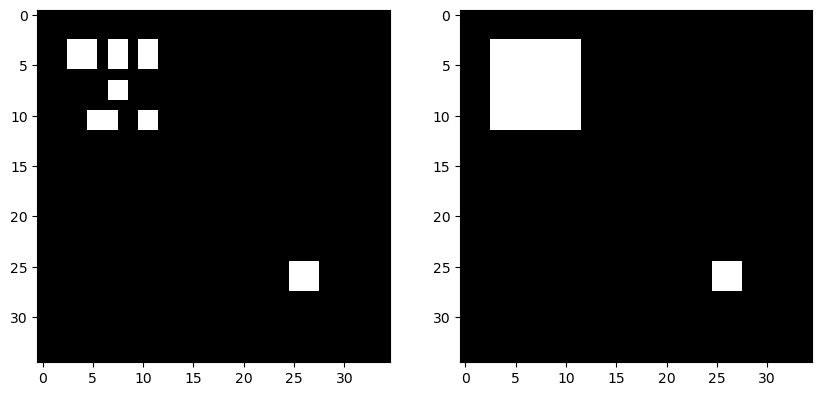

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cc3d
from scipy.ndimage import distance_transform_edt

pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

gt[:, 3:6, 3:6] = 1
gt[:, 3:6, 7:9] = 1
gt[:, 3:6, 10:12] = 1
gt[:, 7:9, 7:9] = 1
gt[:, 10:12, 10:12] = 1
gt[:, 10:12, 5:8] = 1
gt[:, 25:28, 25:28] = 1

pred[:, 3:12, 3:12] = 1
pred[:, 25:28, 25:28] = 1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gt[0], cmap='gray')
ax[1].imshow(pred[0], cmap='gray')

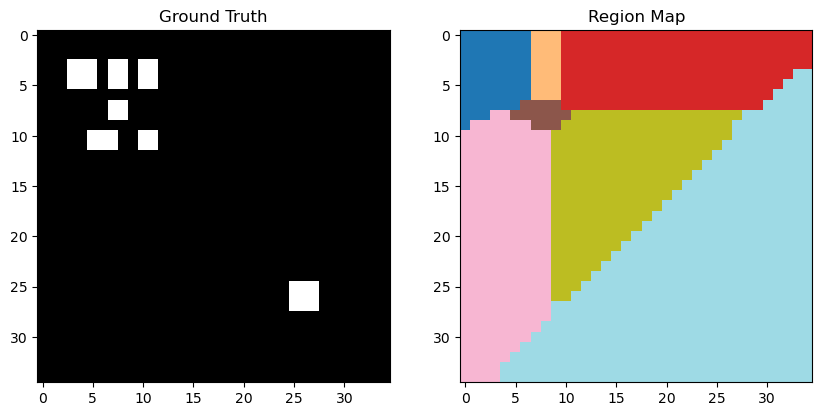

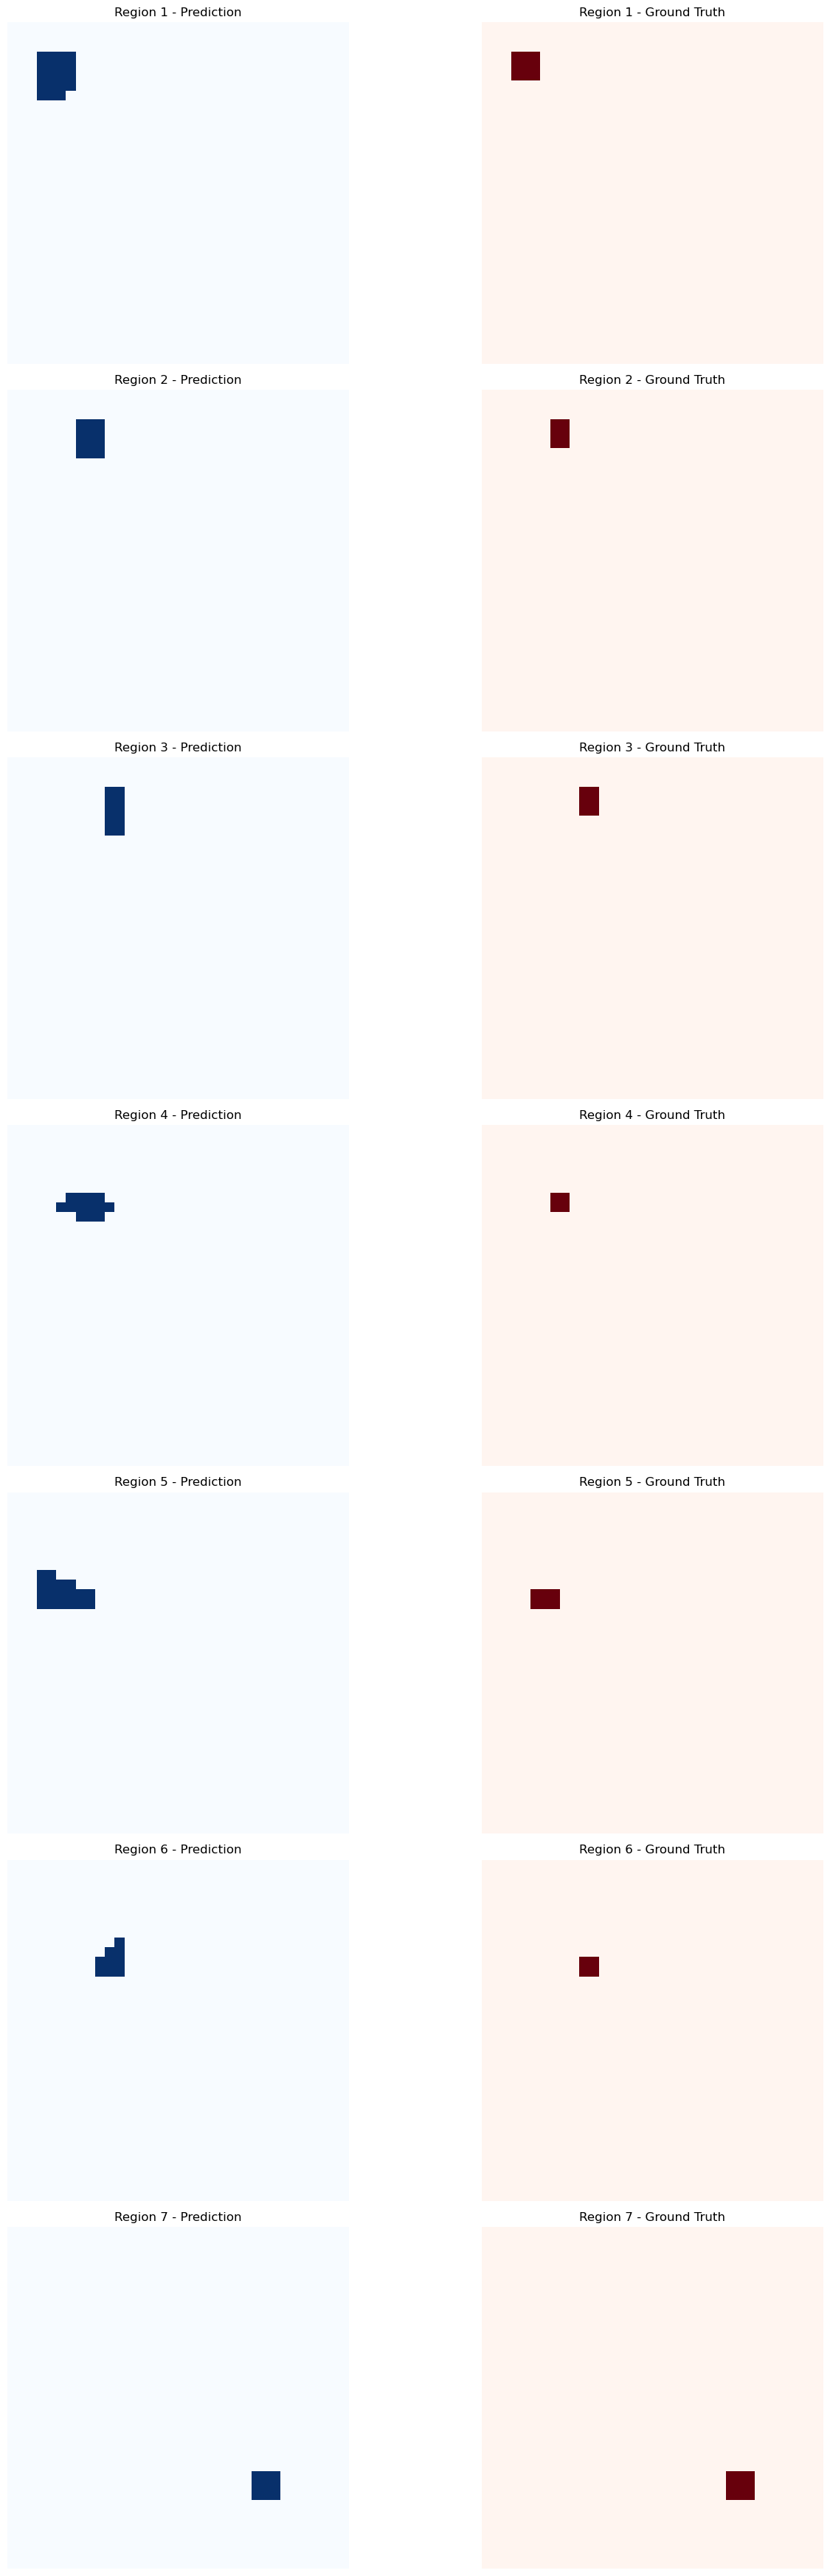

0.6636423799920378

In [9]:
def region_dice(pred, gt, plot=True):
    # Step 1: Identify blob centers and label each region in the ground truth
    labeled_array = cc3d.connected_components(gt)
    num_features = np.max(labeled_array)

    # Step 2: Compute the Euclidean distance transform for each region
    distance_map = np.zeros_like(gt, dtype=float)  # Initialize distance map
    region_map = np.zeros_like(gt, dtype=int)  # Initialize region map

    for region_label in range(1, num_features + 1):
        region_mask = (labeled_array == region_label)  # Create a mask for the current region
        distance = distance_transform_edt(~region_mask)  # Compute distance transform for the background of the current region

        if region_label == 1 or distance_map.max() == 0:
            distance_map = distance  # Initialize or update the distance map
            region_map = region_label * np.ones_like(gt)  # Set the region map
        else:
            update_mask = distance < distance_map  # Find where the current distance is less
            distance_map[update_mask] = distance[update_mask]  # Update distance map
            region_map[update_mask] = region_label  # Update region map

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(gt[0], cmap='gray')
    ax[0].set_title('Ground Truth')
    # ax[1].imshow(pred[0], cmap='Greys')
    # ax[1].set_title('Prediction')
    ax[1].imshow(region_map[0], cmap='tab20')
    ax[1].set_title('Region Map')
    plt.show()

    # Step 3: Calculate Dice coefficient within each region
    dice_scores = []
    if plot:
        fig, axes = plt.subplots(num_features, 2, figsize=(15, 5*num_features))
        if num_features == 1:
            axes = axes[np.newaxis, :]

    for region_label in range(1, num_features + 1):
        region_mask = (region_map == region_label)
        pred_region = pred[region_mask]
        gt_region = gt[region_mask]

        intersection = np.sum(pred_region * gt_region)
        dice_score = (2. * intersection) / (np.sum(pred_region) + np.sum(gt_region) + 1e-8)
        dice_scores.append(dice_score)

        if plot:
            ax_pred, ax_gt = axes[region_label-1]

            # Plot Prediction
            ax_pred.imshow((pred * region_mask)[5], cmap='Blues')
            ax_pred.set_title(f'Region {region_label} - Prediction')
            ax_pred.axis('off')

            # Plot Ground Truth
            ax_gt.imshow((gt * region_mask)[5], cmap='Reds')
            ax_gt.set_title(f'Region {region_label} - Ground Truth')
            ax_gt.axis('off')


    # Calculate the overall Dice score as the average of regional Dice scores
    overall_dice = np.mean(dice_scores)

    if plot:
        plt.tight_layout()
        plt.show()

    return overall_dice

region_dice(pred, gt)

In [3]:
def grounded_region_dice(pred, gt):
    # Step 1: Identify blob centers and label each region in the ground truth
    labeled_array = cc3d.connected_components(gt)
    num_features = np.max(labeled_array)

    # Step 2: Compute the Euclidean distance transform for each region
    distance_map = np.zeros_like(gt, dtype=float)  # Initialize distance map
    region_map = np.zeros_like(gt, dtype=int)  # Initialize region map

    for region_label in range(1, num_features + 1):
        region_mask = (labeled_array == region_label)  # Create a mask for the current region
        distance = distance_transform_edt(~region_mask)  # Compute distance transform for the background of the current region

        if region_label == 1 or distance_map.max() == 0:
            distance_map = distance  # Initialize or update the distance map
            region_map = region_label * np.ones_like(gt)  # Set the region map
        else:
            update_mask = distance < distance_map  # Find where the current distance is less
            distance_map[update_mask] = distance[update_mask]  # Update distance map
            region_map[update_mask] = region_label  # Update region map

    # Step 3: Calculate Dice coefficient within each region
    dice_scores = []

    for region_label in range(1, num_features + 1):
        region_mask = (region_map == region_label)
        pred_region = pred[region_mask]
        gt_region = gt[region_mask]

        intersection = np.sum(pred_region * gt_region)
        dice_score = (2. * intersection) / (np.sum(pred_region) + np.sum(gt_region) + 1e-8)
        dice_scores.append(dice_score)

    # Calculate the overall Dice score as the average of regional Dice scores
    overall_dice = np.mean(dice_scores)

    return overall_dice